## Preface



If need be&#x2026;



In [10]:
!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [11]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [12]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['i','t','m'])
x.columns.name = 'j'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



In [13]:
import cfe

result = cfe.Regression(y=np.log(x.stack()),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Fish (fresh)      0.886778
Milk (fresh)      0.834115
Biscuits          0.781522
Oranges           0.756571
Sorghum           0.686320
Bread             0.677132
Other Fruits      0.658992
Chapati           0.634176
Sweet Bananas     0.591652
Soda              0.586076
Other Veg.        0.585797
Sim Sim           0.563487
Rice              0.531964
Tomatoes          0.488395
Goat              0.467223
Mangos            0.463788
Fish (dried)      0.446381
Matoke            0.443616
Ground Nuts       0.426204
Beef              0.423841
Pork              0.422006
Tea               0.421568
Cooking Oil       0.416759
Maize             0.406007
Cabbages          0.403810
Waragi            0.401824
Dodo              0.369812
Millet            0.360086
Eggs              0.345383
Onions            0.340940
Sweet Potatoes    0.325598
Beans             0.316913
Peas              0.277380
Salt              0.145142
Cassava           0.142661
Name: beta, dtype: float64

Make this persistent&#x2026;



In [14]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [15]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [7]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          54394.359147
Protein          1543.135088
Fiber             719.013180
Folate          11133.452311
Calcium         17461.844887
Carbohydrate     7168.395869
Iron              423.974692
Niacin            431.775192
Riboflavin         38.594788
Thiamin            45.800022
Vitamin A        9683.206362
Vitamin B-12       60.013724
Vitamin B-6        51.591940
Vitamin C        5136.327910
Zinc              238.093310
dtype: float64

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [8]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [9]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.615096,0.722736,0.627115,0.736333,0.355585,1.086926,0.736215,0.664773,0.815046,0.890096,0.345513,0.473890,0.880288,1.792793,0.626514
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.809864,1.089355,0.771282,1.011306,0.544512,1.191057,1.010272,0.920214,1.076578,1.241203,0.456820,0.838280,1.382487,2.355469,0.917791
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.568972,0.785274,0.542669,0.720346,0.338427,0.853769,0.733177,0.646003,0.770529,0.882977,0.328414,0.610290,0.955996,1.634968,0.616956
1013000201,2019-20,Central,5.134721,5.098043,4.132305,3.873524,2.226907,7.438462,7.580828,4.557005,5.250963,6.383922,1.716840,4.348662,5.115286,7.325443,4.520410
1013000202,2019-20,Central,0.743429,1.081666,0.574476,0.776345,0.292498,0.783963,0.761054,0.761700,1.009875,1.084671,0.366327,0.999220,1.091218,1.479722,0.774717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,0.621330,0.806379,0.651366,0.829186,0.353094,0.982076,0.809916,0.685773,0.821752,0.910595,0.353696,0.567944,1.064349,2.324992,0.626486
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,2.627785,2.671846,2.061023,2.015982,1.114663,3.473021,3.770880,2.266925,2.782092,3.168427,1.002933,2.563054,2.670821,3.632937,2.381274
d10a687889de469687377204195f3db0,2019-20,Western,0.658082,0.839498,0.670625,0.776954,0.320558,1.367045,1.163394,0.776283,0.891884,1.036948,0.301277,0.841180,0.998184,1.215716,0.650501


Graph ratios of adequacy for particular nutrients



<Axes: >

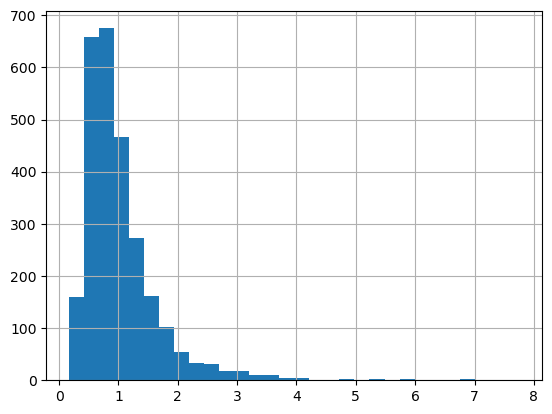

In [10]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)